# *p*-Adic Signals for $\text{GL}_{1}(\mathbb{Q}_p)$.

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import tqdm

## Outline.

### High-level overview.
The primary goal of this notebook to implement the $p$-adic Mellin transform, which takes a *compactly supported locally constant function* $f:\mathbb{Q}^{\times}_{p}\longrightarrow\mathbb{C}$ and a *normalized unitary character* $\omega:\mathbb{Q}^{\times}_{p}\longrightarrow\mathbb{C}^{\times}$, and returns the holomorphic function
    $$
    \widetilde{f}\!\!(s,\omega)
    \ \ :=\ 
    \int_{\mathbb{Q}^{\times}_{p}}\!\!\!f(x)\ \omega(x)\ |x|^{s}_{p}\ d^{\times\!}x.
    $$
The basic idea behind the code that follows is to you the conductors of $f$ and $\omega$ to compute this integral as a finite sum
    $$
    c_{1}\ e^{i 2\pi\lambda_1 t}+c_{2}\ e^{i 2\pi\lambda_2 t}+\cdots+c_{n}\ e^{i 2\pi\lambda_n t},
    $$
for $c_1, c_2,\dots,c_n\in\mathbb{C}$ and $\lambda_1,\lambda_2\,\dots,\lambda_n\in\mathbb{R}$. Because this latter sum is essentially a balanced "chord" of phase-shifted pure oscillators, it is easy to implememnt musically in all sorts of ways. Thinking of the $p$-adic Mellin transform as a spectrum-to-signal operator analogous to the classical Fourier transform, this affords us the possibility of generating "$p$-adic harmonic movement for $\text{GL}_{1}(\mathbb{Q}_{p})$" by preceding the $p$-adic Mellin transform with contravariant $\text{GL}_{1}(\mathbb{Q}_{p})$-translations
    $$
    f(x)\mapsto f(ax).
    $$

### Important Remarks.
* **Noise from round-off error when $\pmb{\omega}$'s conductor is higher than $\pmb{f}$'s conductor.** *(Thank you to Gordon Erlebacher for helping me to understand this point.)* For any normalized unitary character $\omega:\mathbb{Q}^{\times}_{p}\longrightarrow\mathbb{C}^\times$, say with conductor $m\in\mathbb{Z}_{\ge 1}$, and for any $n> m$, we have
    $$
    \sum_{x\in \mathbb{Z}^{\times}_{p}/(1+p^n\mathbb{Z}_{p})}\!\!\!\!\!\!\!\!\!\omega(x)\ =\ 0.
    $$
This is just one of many natural instances that can occur in $\mathbb{Q}^{\times}_{p}$ where we have a finite disjoint collection of open domains $U_1,\dots,U_n\subset\mathbb{Q}^{\times}_{p}$, along with a normalized unitary character $\omega$ that is constant on each of the domains $U_{k}$, and
    $$
    \sum^{n}_{k=1}\omega(U_k)\ =\ 0.
    $$
If $f$ is a compactly supported locally constant function that happens to be constant on some open domain $U\subset\mathbb{Q}^{\times}_{p}$, such that $U_1,\dots,U_n\subset U$, then we immediately have vanishing of the $p$-Mellin ttansform:
    $$
    \widetilde{f}\!\!(s,\omega)
    \ \ =\ 
    \int_{\mathbb{Q}^{\times}_{p}}\!\!\!f(x)\ \omega(x)\ |x|^{s}_{p}\ d^{\times\!}x
    \ \ =\ \ 
    f(U)\cdot\sum^{n}_{k=1}\omega(U_k)\!\int_{U_{k}}\!\!\!|x|^{s}_{p}\ d^{\times\!}x.
    $$
**[Need to correct...]**
The point is that in the code below, this vanishing comes about through floating point arithmetic. But vanishing through floating point arithmetic can lead to double precision noise. **[Need to research a bit more in order to say this correctly]**

### To-do.
* This code is currently only written for the case where $\omega$ is a normalized unitary character. The situation becomes more complicated when we replace $\omega$ by an aribitrary unitary character. This corresponds to the case of the Fourier transform
    $$
    \widehat{f}\!\!(\psi)
    \ \ =\ 
    \int_{\mathbb{Q}^{\times}_{p}}\!\!\!f(x)\ \psi(x)\ d^{\times\!}x
    $$
of $f$ over $\text{GL}_{1}(\mathbb{Q}_{p})$, since every character $\psi$ on $\text{GL}_{1}(\mathbb{Q}_{p})$ factors as the product $\psi(x)=\omega(x)\ |x|^{s}_{p}$ for a unique unitary character. The only difference between a normalized unitary character and a unitary character is the fact that we can have $\omega(p)\ne 1$ for a unitary character that is not normalized. This makes the computation of the Fourier transform more complicated, since the powers $\omega(p)^n$ make an appearance in the computation. When we think of the Fourier transform above as depending on the unitary character $\omega$ and the complex number $s$ in the factorization $\psi(x)=\omega(x)\ |x|^{s}_{p}$, we rewrite it
    $$
    Z_{p}(s, \omega)
    \ \ =\ 
    \int_{\mathbb{Q}^{\times}_{p}}\!\!\!f(x)\ \omega(x)\ |x|^{s}_{p}\ d^{\times\!}x
    $$
and call it a *$p$-adic Zeta function.*

## Classes and functions.

### Class: `p_Approx`
Approximates a non-zero $p$-adic number up to a given order (modulo the number's norm). An instance of `p_Approx` represents an "order-$m$ unit-truncated" $p$-adic number
$$
a\ =\ p^n\cdot(a_0+a_1 p+a_2 p^2+\cdots+a_m p^m)
$$
Attributes:
 * $\text{uniformizer}(a)=p$
 * $\text{ord}_{p}(a)=n$
 * $\text{resol}_{p}(a)=m$
 * $\text{digits}(a)=(a_0,a_1,\dots,a_m)$
 
 * $\text{unit}=a_0+a_1 p+a_2 p^2+\cdots+a_m p^m$

In [233]:
class p_Approx():
    def __init__(self,
                 p,
                 order,
                 digits):
        
        assert isinstance(p, int)
        assert p>=2
        assert isinstance(order, int)
        assert isinstance(digits, list), 'The argument \"digits\" must be a list of integers.'
        assert all(isinstance(d, int) and 0<=d<p for d in digits), 'All digits must be between 0 and p-1.'
        assert (len(digits)>=1 and digits[0]!= 0) or order==0, 'The p-adic number \"0\" can only be represented with order 0 and digits [0].'
        # I need to think more carefully about how to incorporate p-adic 0.
        
        self.uniformizer = p
        self.ord_p = order
        self.resol_p = len(digits)
        self.digits = digits
        
        self.unit = sum([d*p**i for i, d in enumerate(digits)])

#### Testing:

In [3]:
A = p_Approx(7, -5, [1, 2, 6])
print('Associated unit (as integer):', A.unit)
print('Check that unit is correct:', A.unit == 1+2*7+6*7**2)

Associated unit (as integer): 309
Check that unit is correct: True


In [4]:
B = p_Approx(7, 0, [0])
print(B.unit)

0


### Function: `to_p_approx`
Takes an integer $x$ (possibly negative) and a specified conductor $m$ and returns the $p$-adic approximation $p^n u$ of $x$ with unit $u$ approximated up to order $m$.  

In [5]:
def to_p_approx(p: int, x: int, m: int) -> p_Approx:
    assert isinstance(p, int) and p>=2
    assert isinstance(x, int)
    assert isinstance(m, int) and m>=0
    
    order = 0
    while x%(p**order)==0:
        order += 1
    order -= 1
    
    unit = int(x/(p**order))
    
    running_unit = copy.deepcopy(unit)
    digits = []
    k=0
    while len(digits) < m+1:
        d = running_unit%p
        digits.append(d)
        running_unit = running_unit - d
        running_unit = int(running_unit/p)
        k += 1
    
    return p_Approx(p, order, digits)

#### Testing:

In [6]:
A = to_p_approx(7, 49*3, 1)
print('Uniformizer:', A.uniformizer)
print('p-Adic order:', A.ord_p)
print('p-Adic resolution for unit factor:', A.resol_p)
print('p-Adic digits:', A.digits)
print('p-Adic unit factor:', A.unit)

Uniformizer: 7
p-Adic order: 2
p-Adic resolution for unit factor: 2
p-Adic digits: [3, 0]
p-Adic unit factor: 3


In [7]:
A = to_p_approx(7, 49*48, 1)
print('Uniformizer:', A.uniformizer)
print('p-Adic order:', A.ord_p)
print('p-Adic resolution for unit factor:', A.resol_p)
print('p-Adic digits:', A.digits)
print('p-Adic unit factor:', A.unit)

Uniformizer: 7
p-Adic order: 2
p-Adic resolution for unit factor: 2
p-Adic digits: [6, 6]
p-Adic unit factor: 48


In [8]:
A = to_p_approx(3, -1, 10)
print('Uniformizer:', A.uniformizer)
print('p-Adic order:', A.ord_p)
print('p-Adic resolution for unit factor:', A.resol_p)
print('p-Adic digits:', A.digits)
print('p-Adic unit factor:', A.unit)

Uniformizer: 3
p-Adic order: 0
p-Adic resolution for unit factor: 11
p-Adic digits: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
p-Adic unit factor: 177146


### Function: `p_mult`
Multiplies two instances of `p_Approx`, returning a new instance of `p_Approx` with resolution the coarser of the respective resolutions of the two p-adic approximations.

In [9]:
def p_mult(x,y):
    assert isinstance(x, p_Approx)
    assert isinstance(y, p_Approx)
    assert x.uniformizer == y.uniformizer
    
    p = x.uniformizer
    
    order = x.ord_p + y.ord_p
    unit = x.unit * y.unit
    
    resolution = min(x.resol_p, y.resol_p)
    
    output = to_p_approx(p, unit, resolution)
    output.ord_p += order
    
    return output

#### Testing:

In [10]:
x = p_Approx(5, 2, [1, 2, 3])
y = p_Approx(5, -2, [2, 0, 3, 2, 2])

print('Unit of x:', x.unit)
print('Unit of y:', y.unit)

z = p_mult(x, y)

print('\nUniformizer of the product:', z.uniformizer)
print('Order of the product:', z.ord_p)
print('Resolution of the product:', z.resol_p)
print('Digits of the product:', z.digits)
print('Unit of the product:', z.unit)

Unit of x: 86
Unit of y: 1577

Uniformizer of the product: 5
Order of the product: 0
Resolution of the product: 4
Digits of the product: [2, 4, 4, 4]
Unit of the product: 622


### Class: `cslcFunc`
Encodes a compactly supported locally constant function $f$ on $\text{GL}_{1}(\mathbb{Q}_p)$, with conductor $m$, by encoding the cofficients $c_i$ and the dilated-and-translated supporting disks $a_i\cdot(1+p^m\mathbb{Z}_p)$ that define the presentation
    $$
    f(x)
    \ =\ 
    \sum_{i=1}^{k}c_i \cdot \mathbb{1}_{a_i\cdot(1+p^m\mathbb{Z}_{\!p})}(x),
    $$
for disk centers $a_i\in\mathbb{Z}/p^m\mathbb{Z}$ and complex numbers $c_i\in\mathbb{C}$. Note that the supporting disk $a_i\cdot(1+p^m\mathbb{Z}_p)$ has radius $\frac{|a_i|_p}{p^{-m}}$, but that *all supporting disks have the same Haar measure*. Observe here that if
    $$
    a_i
    \ =\ 
    p^n\ (a_{i0}+a_{i1}p+\cdots+a_{ik}p^k),
    $$
for $n\in\mathbb{Z}$ and $k\in\mathbb{Z}_{\ge0}$, then we can rewrite $a_{i}\ (1+p^m\mathbb{Z}_{p})$ as
    $$
    a_{i}\ (1+p^m\mathbb{Z}_{p})
    \ \ =\ \ 
    a_{i0}p^n+a_{i1}p^{n+1}+\cdots+a_{ik}p^{n+k}+p^{n+m}\mathbb{Z}_p.
    $$
Consequently, it only makes sense to choose $a_i\in\mathbb{Q}^\times_p$ with resolution $m$, i.e., such that $k=m-1$. In terms of our class `p_Approx`, this means that `a_i.resol_p` should be $m$.

Attributes:
 * $\text{cond}_p(f)=m$
 * $\text{term_dict}=\{\}$
 
Methods:
 * Contravariant multiplication $f(x)\mapsto f(a^{-1}x)$

In [446]:
class cslcFunc():
    def __init__(self, p, m, supports, values):
        assert isinstance(p, int) and p>=2
        assert isinstance(m, int) and m >= 0
        
        assert isinstance(supports, list)
        assert all(isinstance(a, p_Approx) for a in supports)
        assert all(a.resol_p == m for a in supports)
        
        assert isinstance(values, list)
        assert all(isinstance(c, complex) for c in values)
        
        assert len(supports) == len(values)
        
        self.uniformizer = p
        self.cond_p = m
        self.supp = supports
        self.values = values
        
    def contra_mult(self, b):
        assert isinstance(b, p_Approx)
        assert b.uniformizer == self.uniformizer
        assert b.resol_p == self.cond_p
        
        new_supp = [p_mult(b,a) for a in self.supp]
        self.supp = new_supp
        
        self.cond_p = self.supp[0].resol_p
        assert all(x.resol_p == self.cond_p for x in self.supp)
        
    def eval(self, x):
        assert isinstance(x, p_Approx)
        assert x.resol_p == self.cond_p
        
        output = complex(0., 0.)
        for y in self.supp:
            if y.ord_p == x.ord_p and x.digits == y.digits:
                idx = self.supp.index(y)
                output = self.values[idx]
                
        return output
    
    # I think this next function is written really poorly... 
    # ...probably a good place to start at being a better coder.
    # Here's one thing wrong with this method: it keeps re-calculating the extra digits to append,
    # when they're the same every time. Probably lots of other studities as well.
    def raise_conductor(self, new_cond_p):
        assert isinstance(new_cond_p, int)
        assert new_cond_p >= self.cond_p, 'New conductor must be \u2265 current conductor.'
        
        if new_cond_p == self.cond_p:
            pass
        else:
            p = self.uniformizer
            new_digit_count = new_cond_p - self.cond_p
            new_supp = []
            new_values = []
            for i, x in enumerate(self.supp):
                order = x.ord_p
                value = self.values[i]
                new_digits_collection = [x.digits]
                for k in range(self.cond_p+1, new_cond_p+1):
                    extended_digit_collection = []
                    for digs in new_digits_collection:
                        for l in range(0, p):
                            new_digs = copy.deepcopy(digs)
                            new_digs.append(l)
                            #print('\nNew digs:', new_digs)
                            extended_digit_collection.append(new_digs)
                            #print('\nExtended digits collection:', extended_digit_collection)
                    new_digits_collection = copy.deepcopy(extended_digit_collection)
                    #print('\nNew digits collection:', new_digits_collection)
                new_supp = new_supp + [p_Approx(p, order, digs) for digs in new_digits_collection]
                new_values = new_values + (p**(new_cond_p - self.cond_p)) * [value]
            self.cond_p = new_cond_p
            self.supp = new_supp
            self.values = new_values
            
            assert len(self.supp) == len(self.values)
            

#### Testing:

In [447]:
p = 5
m = 4

w = p_Approx(p, -1, [1, 1, 1, 0])
x = p_Approx(p, -1, [2, 3, 4, 0])
y = p_Approx(p, -1, [3, 2, 3, 3])
z = p_Approx(p, -1, [4, 4, 2, 3])

a = complex(1,1)
b = complex(-1,1)
c = complex(-1,-1)
d = complex(1,-1)

f = cslcFunc(p, m, [w, x, y, z], [a, b, c, d])

f.raise_conductor(6)

In [448]:
x = p_Approx(5, 2, [1, 2, 3])
y = p_Approx(5, -2, [2, 0, 3])

f = cslcFunc(5, 3, [x, y], [complex(1,0), complex(1,2)])
print('Uniformizer of f:', f.uniformizer)
print('Conductor of f:', f.cond_p)
print('Supporting disks of f:', f.supp)
print('Values of f:', f.values)

print(f.eval(x))
print(f.eval(y))
print(f.eval(p_Approx(5, 0, [1, 1, 1])))

Uniformizer of f: 5
Conductor of f: 3
Supporting disks of f: [<__main__.p_Approx object at 0x7fb27878a1f0>, <__main__.p_Approx object at 0x7fb1d95fd0a0>]
Values of f: [(1+0j), (1+2j)]
(1+0j)
(1+2j)
0j


In [449]:
x = p_Approx(5, 2, [1, 2, 3])
y = p_Approx(5, -2, [2, 0, 3])

f = cslcFunc(5, 3, [x, y], [complex(1,0), complex(1,2)])

print('\nOriginal support orders:')
for a in f.supp:
    print(a.ord_p)

z = p_Approx(5, -4, [1, 1, 1])
f.contra_mult(z)

print('\nNew support orders:')
for a in f.supp:
    print(a.ord_p)


Original support orders:
2
-2

New support orders:
-2
-6


In [450]:
x = p_Approx(5, 2, [1, 2, 3])
y = p_Approx(5, -2, [2, 0, 3])

f = cslcFunc(5, 3, [x, y], [complex(1,0), complex(1,2)])
print('Conductor of f:', f.cond_p)
print('Supporting disks of f:', f.supp)
print('Values of f:', f.values)

f.raise_conductor(4)
print('Conductor of f:', f.cond_p)
print('Supporting disks of f:', f.supp)
print('Values of f:', f.values)

Conductor of f: 3
Supporting disks of f: [<__main__.p_Approx object at 0x7fb208033e80>, <__main__.p_Approx object at 0x7fb208033970>]
Values of f: [(1+0j), (1+2j)]
Conductor of f: 4
Supporting disks of f: [<__main__.p_Approx object at 0x7fb208033880>, <__main__.p_Approx object at 0x7fb2080330a0>, <__main__.p_Approx object at 0x7fb2080339d0>, <__main__.p_Approx object at 0x7fb208033640>, <__main__.p_Approx object at 0x7fae4aa2e940>, <__main__.p_Approx object at 0x7fae4aa2ea60>, <__main__.p_Approx object at 0x7fb25b3016a0>, <__main__.p_Approx object at 0x7fb25b301c10>, <__main__.p_Approx object at 0x7fb25b301910>, <__main__.p_Approx object at 0x7fb25b3018e0>]
Values of f: [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+2j), (1+2j), (1+2j), (1+2j), (1+2j)]


### Function: `primitive_root`
Returns a list of primitive roots modulo $p^m$ for some prime $m$ and conductor $m$.

In [451]:
def primitive_root(p, m):
    assert isinstance(p, int)
    assert p >=2
    assert isinstance(m, int)
    assert m >=1
    
    print('\nComputing primitive root modulo p\u005Em =', p**m, '\n')
    
    candidates = [i for i in range(1,p**m)]
    for k in tqdm.tqdm(range(1,p**(m-1))):
        if k*p in candidates:
            candidates.remove(k*p)
        
    totient = len(candidates)
    
    for a in candidates:
        powers = []
        for k in tqdm.tqdm(range(1, totient+1)):
            kth_power = (a**k)%(p**m)
            if kth_power in powers:
                break
            else:
                powers.append(kth_power)
        if set(powers) == set(candidates):
            output = a
            break
    
    return output

#### Testing:

In [452]:
primitive_root(37, 3)


Computing primitive root modulo p^m = 50653 



100%|██████████████████████████████████████████████████████████████████████| 49284/49284 [00:15<00:00, 3283.30it/s]


2

In [453]:
primitive_root(7, 3)


Computing primitive root modulo p^m = 343 



100%|████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 336001.46it/s]


3

### Class: `nuCharacter`
Encodes a normalized unitary $p$-adic character $\omega:\mathbb{Q}^{\times}_{p}\longrightarrow\mathbb{C}^{\times}$. Such a character is completely determined by its restriction $\omega|_{\mathbb{Z}^{\times}_{p}}:\mathbb{Z}^\times_p\longrightarrow\mathbb{S}^1$, which necessarily factors through a character
    $$
    \overline{\omega}:(\mathbb{Z}/p^m\mathbb{Z})^\times\longrightarrow\mathbb{S}^1,
    $$
for some $m$. The minimal such $m$ is called the *conductor* of $\omega$.

**Remark.** This code is not correct for the case $p=2$. In that case, $(\mathbb{Z}/2^{m}\mathbb{Z})^\times\cong(\mathbb{Z}/2\mathbb{Z})\ \times\ (\mathbb{Z}/2^{m-2}\mathbb{Z})$, hence the normalized unitary character is defined by a choice of $(2^{m-2})^\text{th}$-root of unity $\zeta\in\mathbb{C}$ and a choice of sign $\pm 1\in\mathbb{C}$.

In [454]:
class nuCharacter():
    def __init__(self, p, m, l):
        assert isinstance(p, int)
        assert p>=2
        assert isinstance(m, int)
        assert m>=1
        assert isinstance(l, int)
        
        self.totient = (p-1) * p**(m-1)
        if l >= self.totient: print('\nTotient is φ(p\u005Em) =', self.totient)
        if l >= self.totient: print('You\'re using the argument l =', l, '\u2265 φ(p\u005Em).')
        assert 0 <= l < self.totient, 'The argument l must be non-negative and must be less than the totient φ(p\u005Em) = (p-1)\u00B7p\u005E(m-1).'
        
        assert p!=2, 'You need to fix the p = 2 case.'
        
        self.uniformizer = p
        self.cond_p = m
        self.gen_multiple = l
        
        # Returns `self.theta`, representing lth power of e^(i2*pi/totient):
        self.primitive_theta = 2*np.pi/self.totient
        self.gen_theta = self.gen_multiple * self.primitive_theta
        self.gen_X = np.cos(self.gen_theta)
        self.gen_Y = np.sin(self.gen_theta)
        self.zeta = complex(self.gen_X, self.gen_Y)
        
        self.primitive_root = primitive_root(self.uniformizer, self.cond_p)
        # The combination of the choice of l and the value returned by `self.primitive_root` are what determine the specific character.
        
        self.powers = {k: (self.primitive_root**k)%(self.uniformizer**self.cond_p) for k in range(self.totient)}
        self.disc_logs = {self.powers[k]: k for k in self.powers}
        
        self.pseudo_cond_p = m
        self.times_raised = 0
        
        
    def eval(self, x):
        assert isinstance(x, p_Approx)
        assert x.resol_p == self.pseudo_cond_p
        
        unit = x.unit%(self.uniformizer**self.cond_p)
        out_multiple = self.disc_logs[unit]
        out_X = np.cos(out_multiple * self.gen_theta)
        out_Y = np.sin(out_multiple * self.gen_theta)
        
        output = complex(out_X, out_Y)
        
        return output
    
    # Re-interpret our nuCharacter as having a higher conductor.
    # This amounts to viewing the nuCharacter's arguments at a different resolution.
    def raise_conductor(self, new_cond_p):
        assert isinstance(new_cond_p, int)
        assert new_cond_p >= self.cond_p, 'New conductor must be \u2265 current conductor.'
        
        if new_cond_p == self.cond_p:
            pass
        else:
            self.pseudo_cond_p = new_cond_p
            self.times_raised += 1
            

#### Testing:

In [455]:
omega = nuCharacter(7, 3, 10)
print(omega.zeta)

z = p_Approx(7, -2, [2, 0, 3])
print(z.unit)
omega.eval(z)


Computing primitive root modulo p^m = 343 



100%|████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 365587.13it/s]

(0.977249996460544+0.21209065141553668j)
149


(-0.9616534368410361+0.274267510674931j)


Computing primitive root modulo p^m = 625 



100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 246927.12it/s]


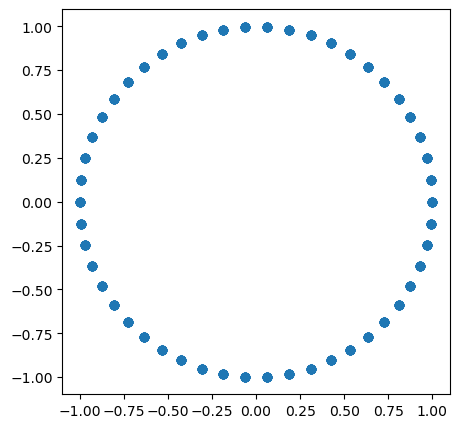

In [456]:
p = 5
m = 4

omega = nuCharacter(p, m, 10)

#print('\nDiscrete logarithms dictionary:\n', omega.disc_logs)

possibilities = [[]]
for i in range(m):
    new_possibilities = []
    for digs in possibilities:
        for k in range(p):
            new_digs = copy.deepcopy(digs)
            new_digs.append(k)
            new_possibilities.append(new_digs)
    possibilities = copy.deepcopy(new_possibilities)
    
corrected_possibilities = []
for digs in possibilities:
    if digs[0] != 0:
        corrected_possibilities.append(digs)
possibilities = corrected_possibilities
#print(possibilities)

#print('\npossibilities[0] = ', possibilities[0], '\n')

#print('\np-Adic digits to evaluate:\n', possibilities)

X_coords = []
Y_coords = []
for digs in possibilities:
    z = p_Approx(p,0,digs)
    #print(z.unit)
    s = omega.eval(z)
    X_coords.append(s.real)
    Y_coords.append(s.imag)
    
plt.figure(figsize=(5,5))
plt.scatter(X_coords, Y_coords)
plt.show()

In [457]:
p = 5
m = 4

omega = nuCharacter(p, m, 10)

x = p_Approx(p, m, [1,1,1,1])
y = p_Approx(p, m+2, [1,1,1,1,1,1])
z = p_Approx(p, m+2, [1,1,1,1,1,1, 1])

print('\nPseudo conductor:', omega.pseudo_cond_p)
print('Number of times the conductor has been raised:', omega.times_raised)
print('Evaluation of \u03C9 at x before raising the conductor:', omega.eval(x))

omega.raise_conductor(m+2)

print('\nPseudo conductor:', omega.pseudo_cond_p)
print('Number of times the conductor has been raised:', omega.times_raised)
print('Evaluation of \u03C9 at lift of x after raising the conductor:', omega.eval(y))

omega.raise_conductor(m+3)

print('\nPseudo conductor:', omega.pseudo_cond_p)
print('Number of times the conductor has been raised:', omega.times_raised)
print('Evaluation of \u03C9 at lift of x after raising the conductor:', omega.eval(z))


Computing primitive root modulo p^m = 625 



100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 247393.18it/s]


Pseudo conductor: 4
Number of times the conductor has been raised: 0
Evaluation of ω at x before raising the conductor: (0.9685831611286312-0.24868988716485457j)

Pseudo conductor: 6
Number of times the conductor has been raised: 1
Evaluation of ω at lift of x after raising the conductor: (0.9685831611286312-0.24868988716485457j)

Pseudo conductor: 7
Number of times the conductor has been raised: 2
Evaluation of ω at lift of x after raising the conductor: (0.9685831611286312-0.24868988716485457j)


### Class: `PhasedChord`
Encodes a sum
    $$
    F(b, t)\ =\ c_1\ A^{b}_{1}e^{i2\pi\lambda_1 t}+c_2\ A^{b}_{2}e^{i2\pi\lambda_2 t} +\cdots+c_n\ A^{b}_{n}e^{i2\pi\lambda_n t},
    $$
for $c_1,c_2,\dots,c_n\in\mathbb{C}$, $A_1, A_2, \cdots, A_n\in\mathbb{R}_{>0}$, and $\lambda_1,\lambda_2,\dots,\lambda_n\in\mathbb{R}$, along with a method for evaluating the sum at *time* $t\in\mathbb{R}$.

In [458]:
class PhasedChord():
    def __init__(self, coeff_list, ampl_list, freq_list):
        assert isinstance(coeff_list, list)
        assert all(isinstance(c, complex) for c in coeff_list)
        assert isinstance(ampl_list, list)
        assert all(isinstance(A, float) and A >= 0 for A in ampl_list)
        assert isinstance(freq_list, list)
        assert all(isinstance(l, float) for l in freq_list)
        assert len(coeff_list) == len(freq_list) == len(ampl_list)
        
        self.coefficients = coeff_list
        self.amplitudes = ampl_list
        self.frequencies = freq_list
        
        self.term_count = len(self.coefficients)
        
    def eval(self, b, t):
        assert isinstance(t, float)
        
        I = complex(0.,1.)
        c = self.coefficients
        A = self.amplitudes
        l = self.frequencies
        n = self.term_count
        
        theta = [2*np.pi*l[k]*t for k in range(n)]
        
        term_list = [c[k] * A[k]**(b) * np.exp(I*2*np.pi*l[k]*t) for k in range(n)]
        output = sum(term_list)
        
        return output

#### Testing:

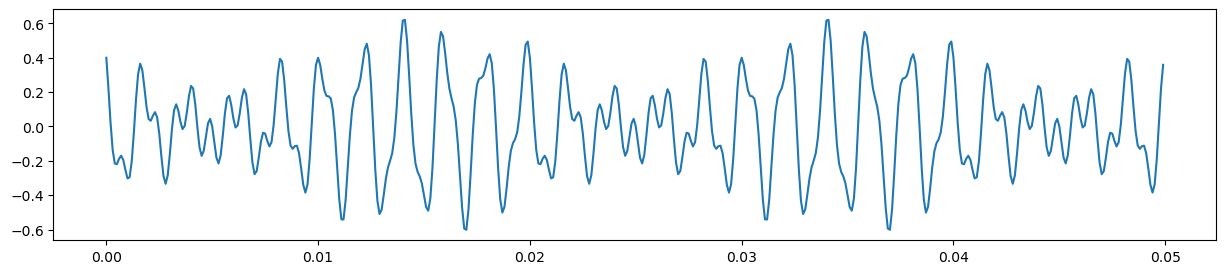

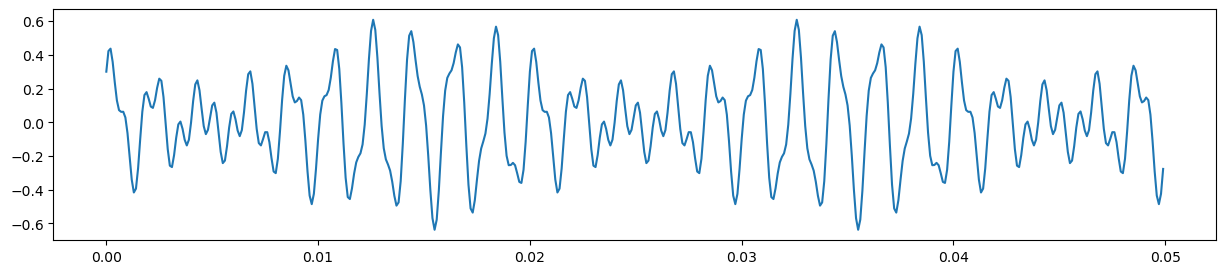

In [459]:
c_ = [complex(1, 0), complex(0,1), complex(1,1)]
A_ = [.3, .2, .1]
l_ = [500., 550., 1200.]
chord = PhasedChord(c_, A_, l_)

T = [.0001*j for j in range(500)]
X = [chord.eval(1, t).real for t in T]
Y = [chord.eval(1, t).imag for t in T]

plt.figure(figsize=(15,3))
plt.plot(T, X)
plt.show()

plt.figure(figsize=(15,3))
plt.plot(T, Y)
plt.show()

### Class: `p_Mellin`
Returns the $p$-adic Mellin transform
    $$
    \widetilde{f}\!\!(s,\ \omega)
    \ \ =\ 
    \int_{\mathbb{Q}^{\times}_{p}}\!\!f(x)\ \omega(x)\ |x|^{s}_{p}\ d^\times\! x
    $$
as a `PhasedChord` instance.

In [460]:
class p_Mellin():
    def __init__(self, f, omega):
        assert isinstance(f, cslcFunc)
        assert isinstance(omega, nuCharacter)
        assert f.uniformizer == omega.uniformizer
        
        self.uniformizer = f.uniformizer
        #print('p =', self.uniformizer)

        self.joint_cond = max(f.cond_p, omega.cond_p)
        #print('Joint conductor =', self.joint_cond)

        self.func = copy.deepcopy(f)
        #print('Conductor of f =', self.func.cond_p)
        self.char = copy.deepcopy(omega)
        #print('Conductor of \u03C9 =', self.char.cond_p)

        self.func.raise_conductor(self.joint_cond)
        #print('Raised conductor of f =', self.func.cond_p)
        self.char.raise_conductor(self.joint_cond)
        #print('Raised conductor of \u03C9 =', self.char.cond_p)
        #print('Raised pseudo-conductor of \u03C9 =', self.char.pseudo_cond_p)
        
        assert self.func.cond_p == self.char.pseudo_cond_p

        self.supp_count = len(self.func.supp)
        
        coeff_list = []
        ampl_list = []
        freq_list = []
        p = self.uniformizer
        m = self.func.cond_p
        for k in range(self.supp_count):
            c_k = self.func.values[k]
            x_k = self.func.supp[k]
            n_k = x_k.ord_p
            w_k = self.char.eval(x_k)
            
            new_coeff = (p/(p-1)) * p**(-m) * c_k * w_k
            coeff_list.append(new_coeff)
            
            A_k = float(p**(-n_k))
            ampl_list.append(A_k)
            
            new_freq = -n_k * np.log(p)
            freq_list.append(new_freq)
            
        self.coeff_list = coeff_list
        self.ampl_list = ampl_list
        self.freq_list = freq_list
        
        self.chord = PhasedChord(self.coeff_list, self.ampl_list, self.freq_list)
    
    def eval(self, b, t):
        output = self.chord.eval(b, t)
        return output

#### Testing:


ordₚ(x₁) = 1
ordₚ(x₁) = 3
ordₚ(x₁) = 0

Computing primitive root modulo p^m = 9 



100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 158275.62it/s]


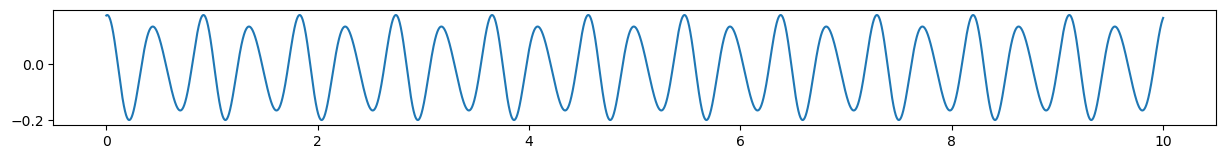


Computing primitive root modulo p^m = 9 



100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 201326.59it/s]


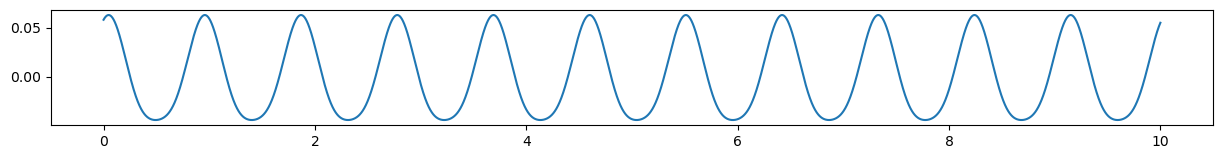


Computing primitive root modulo p^m = 9 



100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 177224.11it/s]


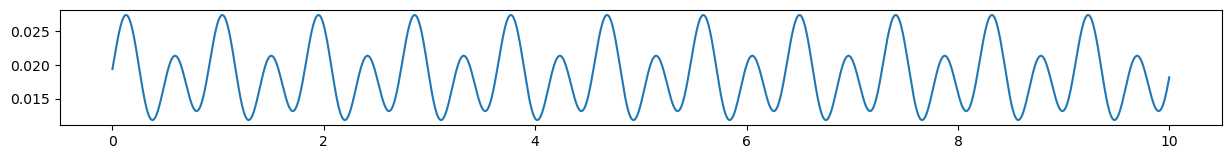


Computing primitive root modulo p^m = 9 



100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 154391.56it/s]


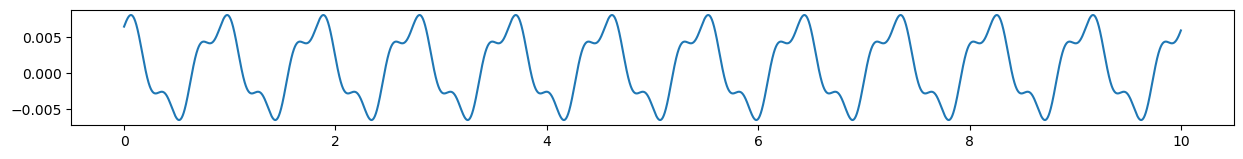


Computing primitive root modulo p^m = 9 



100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 115439.56it/s]


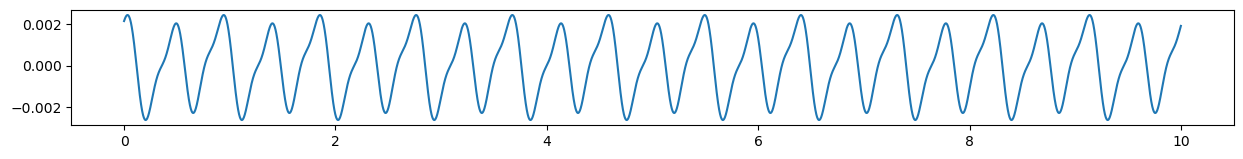


Computing primitive root modulo p^m = 9 



100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 139810.13it/s]


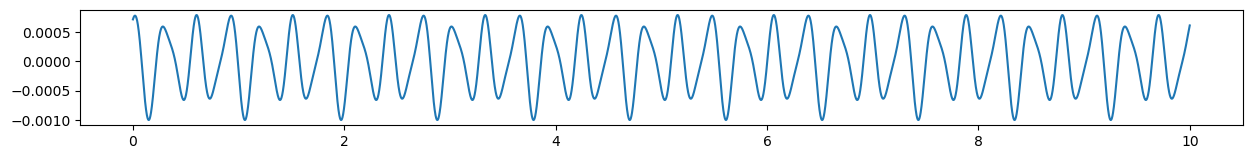

In [475]:
p = 3
m = 3

x_1 = p_Approx(p, 1, [1,0,0])
print('\nord\u209A(x\u2081) =', x_1.ord_p)
x_2 = p_Approx(p, 3, [2,0,0])
print('ord\u209A(x\u2081) =', x_2.ord_p)
x_3 = p_Approx(p, 0, [1,1,0])
print('ord\u209A(x\u2081) =', x_3.ord_p)

c_1 = complex(1.,0.)
c_2 = complex(0.,1.)
c_2 = complex(2.,2.)

for k in range(-3,3):
    f = cslcFunc(p, m, [x_1, x_2, x_3], [c_1, c_2, c_3])
    f.contra_mult(p_Approx(p,k,[1,0,0]))

    omega = nuCharacter(p, 2, 1)

    F = p_Mellin(f, omega)

    T = [.001*j for j in range(10000)]
    X = [F.eval(1, t).real for t in T]

    plt.figure(figsize=(15,1.5))
    plt.plot(T, X)
    plt.show()